In [1]:
from datetime import timedelta, date

def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

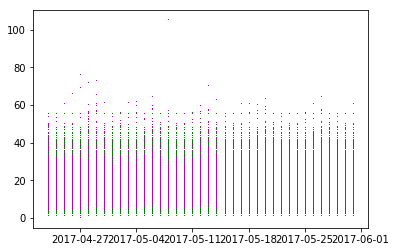

In [2]:
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline


def split_out_id(df: pd.DataFrame) -> pd.DataFrame:
    """Returns df with an additional column of type DateTime read from the id column."""
    df['visit_date'] = pd.to_datetime(df['id'].map(lambda x: str(x).split('_')[2]))
    df['air_store_id'] = df['id'].map(lambda x: '_'.join(x.split('_')[:2]))
    return df

lgb = split_out_id(pd.read_csv("LGB_sub.csv")) # 0.601
lgb_cv = split_out_id(pd.read_csv("LGB_CV_sub.csv")) # 1.080 (now 0.756)

date_info = pd.read_csv("data/date_info.csv", parse_dates=["calendar_date"])

plt.plot(lgb["visit_date"], lgb["visitors"], "g,", lgb_cv["visit_date"], lgb_cv["visitors"], "m,")

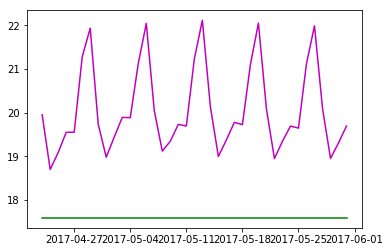

In [3]:
avg = lgb.groupby("visit_date").mean()
avg_cv = lgb_cv.groupby("visit_date").mean()
plt.plot(avg.index, avg["visitors"], "g-", avg_cv.index, avg_cv["visitors"], "m-")

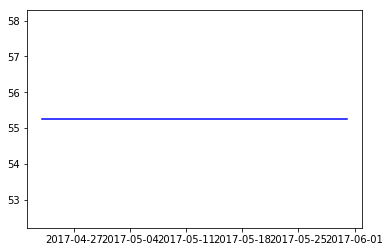

In [4]:
maxes = lgb.groupby("visit_date").max()
plt.plot(maxes.index, maxes["visitors"], "b-")

Plotting by store and date rather than id column

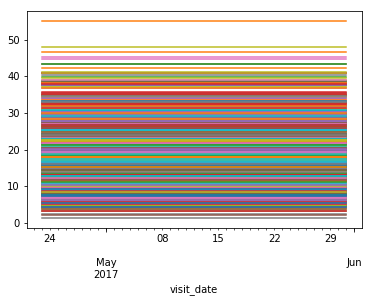

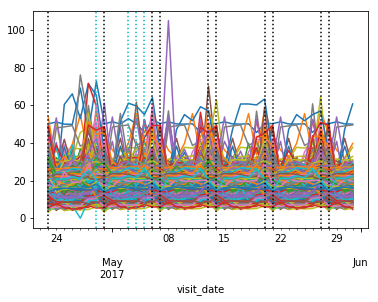

In [5]:
# Create pandas dataframe with index date columns air_store_id values visitors
stores = lgb.pivot_table(values="visitors", index="visit_date", columns="air_store_id", aggfunc="first")
stores_cv = lgb_cv.pivot_table(values="visitors", index="visit_date", columns="air_store_id", aggfunc="first")

lines = [linedate
         for linedate
         in date_range(stores_cv.index.min(), stores_cv.index.max() + timedelta(1))
         if date_info[date_info["calendar_date"] == linedate]["holiday_flg"].iloc[0]
         or date_info[date_info["calendar_date"] == linedate]["day_of_week"].iloc[0] in ("Saturday","Sunday")]

def add_date_info(graph: mplt.axes.Axes) -> mplt.axes.Axes:
    global lines # technically unecessary: function does not modify state, but is affected by it
    [graph.axvline(x=date, color=('c' 
                                  if date_info[date_info["calendar_date"] == date]["holiday_flg"].iloc[0]
                                  else 'k'), linestyle=':') for date in lines]
    return graph

stores.plot().legend().set_visible(False)
add_date_info(stores_cv.plot()).legend().set_visible(False)

Examining specific stores in relation to holiday and weekend data

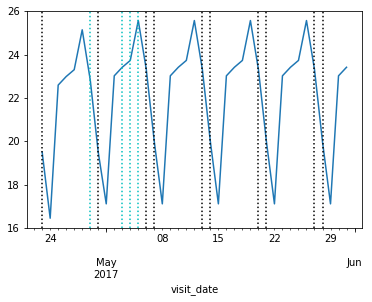

In [6]:
def graph_one_store(df, id: str) -> mplt.axes.Axes: add_date_info(df[id].plot())

graph_one_store(stores_cv, "air_06f95ac5c33aca10")

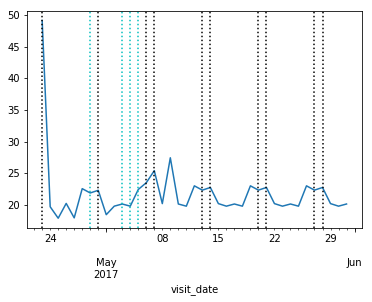

In [7]:
graph_one_store(stores_cv, "air_56cebcbd6906e04c")

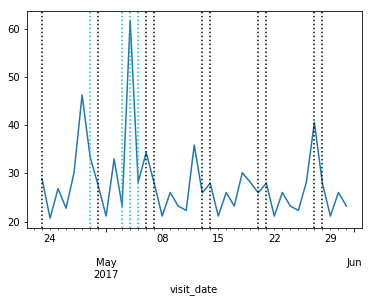

In [8]:
graph_one_store(stores_cv, "air_e55abd740f93ecc4")

Examining outlier store from non-cv in cv

In [9]:
print(','.join(lgb.groupby("visit_date").max()["air_store_id"].unique()))

air_fff68b929994bfbd


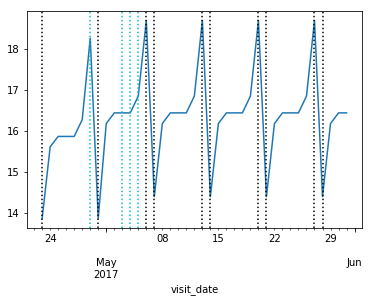

In [10]:
graph_one_store(stores_cv, "air_fff68b929994bfbd")

Examining the impact of the weekend on overall data

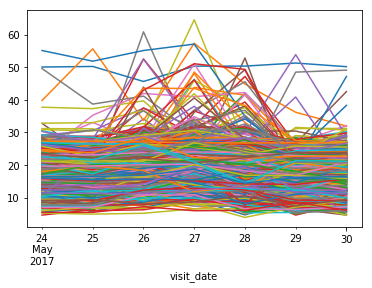

In [11]:
one_week = stores_cv[pd.Timestamp("2017-05-24") <= stores_cv.index]
one_week = one_week[one_week.index<=pd.Timestamp("2017-05-30")]
short_graph = one_week.plot()
short_graph.legend().set_visible(False)
# May 27th is a Saturday

Examining anomalous stores

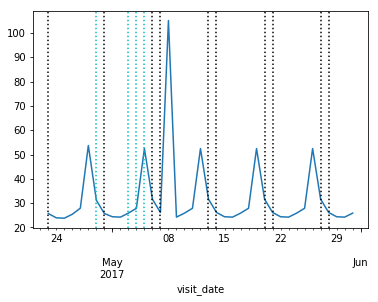

In [12]:
# graph the store with the highest value on 2017-05-08
graph_one_store(stores_cv,
                stores_cv[stores_cv.index == pd.Timestamp("2017-05-08")].idxmax(axis=1).values[0])

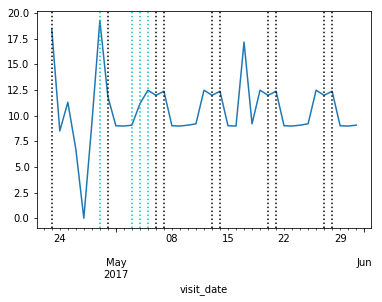

In [13]:
# graph the store with the lowest value on 2017-04-27
graph_one_store(stores_cv,
                stores_cv[stores_cv.index == pd.Timestamp("2017-04-27")].idxmin(axis=1).values[0])

analyzing different aspects of data

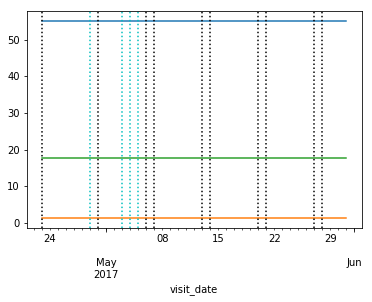

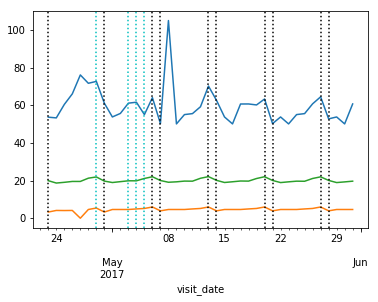

In [14]:
for df in (stores, stores_cv):
    df["mean"] = df.mean(axis=1)
    df["max"] = df.max(axis=1)
    df["min"] = df.min(axis=1)
    df["stdd"] = df.std(axis=1)
    df["range"] = df["max"] - df["min"]

stat = stores[["max", "min", "mean"]]
add_date_info(stat.plot()).legend().set_visible(False)
stat_cv = stores_cv[["max", "min", "mean"]]
add_date_info(stat_cv.plot()).legend().set_visible(False)

- mean lies closer to lower end of range: more outliers at top end?
- max values also less smooth for CV: feeds into ^
- min value high for CV

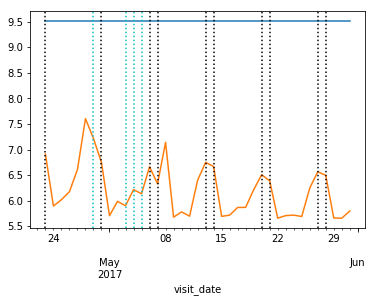

In [15]:
std_dev = stores["stdd"].plot()
stores_cv["stdd"].plot(ax=std_dev)
add_date_info(std_dev)

- more variance even at lowest points in CV
- more variance on weekends; likely due to some stores spiking significantly while others remain relatively low
- possibly also due to increased number of visits on weekends
- minimums towards start and middle of week most likely due to low number of visits
- holidays show similar impact to weekends on a lesser scale? more just "disruption" which is consistent with data

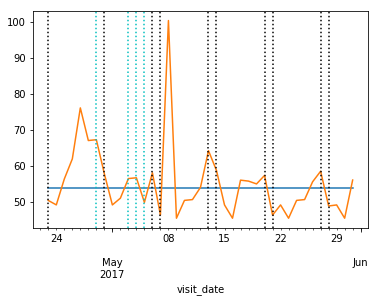

In [18]:
range_plot = stores["range"].plot()
stores_cv["range"].plot(ax=range_plot)
add_date_info(range_plot)

- range difference between models isn't too large: possibly worth shifting cv data down to hit x-axis?
- same trends noticed in stddev carry through to range